In [25]:
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from types import SimpleNamespace

import pySPEC as ps
from pySPEC.time_marching import SWHD_1D, Adjoint_SWHD_1D

param_path = 'examples/adjoint'
# Parse JSON into an object with attributes corresponding to dict keys.
fpm = json.load(open(f'{param_path}/forward_params.json', 'r'), object_hook=lambda d: SimpleNamespace(**d))
bpm = json.load(open(f'{param_path}/backward_params.json', 'r'), object_hook=lambda d: SimpleNamespace(**d))
fpm.Lx = 2*np.pi*fpm.Lx
grid   = ps.Grid1D(fpm)


In [11]:
dgs = [np.load(f'{fpm.hb_path}/dg_{ii}.npy') for ii in range(1,3)] # only t = 0 h_ux

Nt = round(fpm.T/fpm.dt)
h_uxs =  [np.load(f'{bpm.out_path}/h_ux_{step:04}.npy') for step in range(Nt)] # all t h_ux
hx_uus =  [np.load(f'{bpm.out_path}/hx_uu_{step:04}.npy') for step in range(Nt)] # all t hx_uu

In [58]:
# h_ux mean and max
mh_uxs = [h_ux.mean() for h_ux in h_uxs]
Mh_uxs = [h_ux.max() for h_ux in h_uxs]
argmaxh_ux =  np.argmax(np.array(mh_uxs))
maxh_ux =  np.array(mh_uxs).max()
# integrate h_ux in time
Th_uxs = np.array(h_uxs).sum(axis=0)
print('check shape of integral h_ux :  ' , Th_uxs.shape)
# integrate h_ux in time and space
XTh_uxs = np.array(h_uxs).sum()
print('integral in space-time h_ux = ', XTh_uxs)



# hx_uu mean and max
mhx_uus = [hx_uu.mean() for hx_uu in hx_uus]
Mhx_uus = [hx_uu.max() for hx_uu in hx_uus]
argmaxhx_uu =  np.argmax(np.array(mhx_uus))
maxhx_uu =  np.array(mhx_uus).max()
# integrate hx_uu in time
Thx_uus = np.array(hx_uus).sum(axis=0)
print('check shape of integral h_ux :  ' , Thx_uus.shape)
# integrate hx_uu in time and space
XThx_uus = np.array(hx_uus).sum()
print('integral in space-time h_ux = ', XThx_uus)

tts = [tt for tt in range(len(h_uxs))]

# get uu for argmaxh_ux
hh_max = np.load(f'{fpm.data_path}/hh_{argmaxh_ux:04}.npy')
hb = np.load(f'{fpm.data_path}/hb.npy')


check shape of integral h_ux :   (1024,)
integral in space-time h_ux =  2888.141314848681
check shape of integral h_ux :   (1024,)
integral in space-time h_ux =  -2888.202237795489


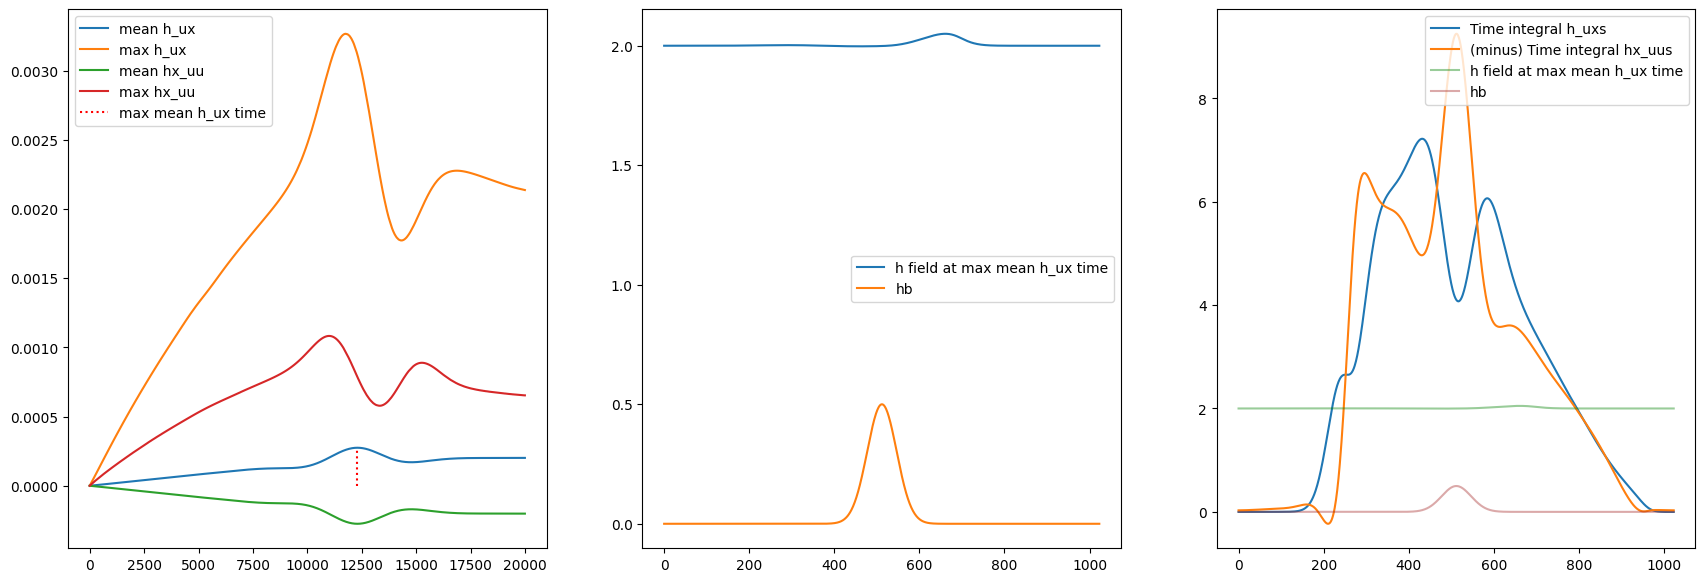

In [65]:
f,axs = plt.subplots(ncols=3 , figsize = (21,7))

axs[0].plot(tts , mh_uxs , label = 'mean h_ux' )
axs[0].plot(tts , Mh_uxs , label = 'max h_ux' )
axs[0].plot(tts , mhx_uus , label = 'mean hx_uu' )
axs[0].plot(tts , Mhx_uus , label = 'max hx_uu' )
axs[0].vlines(argmaxh_ux , 0 , maxh_ux, linestyles='dotted', color = 'red', label = 'max mean h_ux time')
axs[0].legend()

axs[1].plot(hh_max, label = 'h field at max mean h_ux time')
axs[1].plot(hb, label = 'hb')
axs[1].legend()

axs[2].plot(Th_uxs , label = 'Time integral h_uxs')
axs[2].plot( - Thx_uus , label = '(minus) Time integral hx_uus')
axs[2].plot(hh_max, label = 'h field at max mean h_ux time' , alpha = 0.4 , color = 'green')
axs[2].plot(hb, label = 'hb' , alpha = 0.4 , color = 'brown')
axs[2].legend()
